In [1]:
import sys, os
%load_ext autoreload
%autoreload 2
sys.path.append('../../src')
sys.path.append(os.path.abspath(os.path.join('..')))
import utils

import torch
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import hist
from hist import Hist

from torch.utils.data import DataLoader
from torch.nn import Sigmoid

from tensordict.nn import TensorDictModule, TensorDictSequential

from deepmuonreco.data import InnerTrackSelectionDataset
from deepmuonreco.nn import InnerTrackSelectionTransformer, Normalize
from deepmuonreco.nn.utils import init_params
from deepmuonreco.nn import SelectedBCEWithLogitsLoss

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from tqdm import tqdm
import json

plt.style.use(hep.style.CMS)

In [2]:
model_path = "9c1d2c41dba54beeb0c57456"
checkpoint_path = f"../../.aim/default/{model_path}/best_model.pt"
norm_stats_path = "../../configs/norm-stats/mu2024pu1M.json"

mu2024pu_path = "../../data/mu2024pu/test.root"
ttbar2024pu_path = "../../data/ttbar2024pu/test.root"

In [3]:
torch.set_num_threads(32)
torch.set_num_interop_threads(32)

In [4]:
mu2024pu = InnerTrackSelectionDataset(path=mu2024pu_path)
ttbar2024pu = InnerTrackSelectionDataset(path=ttbar2024pu_path)

print(f"Muon dataset loaded: {len(mu2024pu)}")
print(f"TTbar dataset loaded: {len(ttbar2024pu)}")

Muon dataset loaded: 19999
TTbar dataset loaded: 19999


In [5]:
data_loader = DataLoader(
    dataset=test_set,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    collate_fn=InnerTrackSelectionDataset.collate
)

device = torch.device("cpu")

with open(norm_stats_path, "r") as f:
    norm_stats = json.load(f)

model = utils.load_model(
    checkpoint_path=checkpoint_path,
    device=device,
    dim_model=128,
    dim_feedforward=256,
    num_heads=8,
    num_layers=4,
    norm_stats=norm_stats
)

NameError: name 'test_set' is not defined

In [6]:
tracks, segs, hits = [], [], []
targets, logits, scores = [], [], []
with torch.no_grad():
    model = model.to(device).eval()
    for batch in tqdm(test_loader):
        output = model(batch)

        track_mask = ~batch["pad_masks"]["track"].view(-1)
        seg_mask = ~batch["pad_masks"]["seg"].view(-1)
        hit_mask = ~batch["pad_masks"]["hit"].view(-1)

        track = batch["track"].reshape(-1, batch["track"].shape[-1])[track_mask]
        seg   = batch["seg"].reshape(-1, batch["seg"].shape[-1])[seg_mask]
        hit   = batch["hit"].reshape(-1, batch["hit"].shape[-1])[hit_mask]

        target = batch["target"].reshape(-1)[track_mask]
        logit  = output["logits"].reshape(-1)[track_mask]
        score  = output["score"].reshape(-1)[track_mask]

        tracks.append(track)
        segs.append(seg)
        hits.append(hit)
        targets.append(target)
        logits.append(logit)
        scores.append(score)


100%|██████████| 199994/199994 [50:13<00:00, 66.37it/s]  


In [7]:
tracks  = torch.cat(tracks).numpy() * norm_stats['track'][1] + norm_stats['track'][0]
segs    = torch.cat(segs).numpy() * norm_stats['seg'][1] + norm_stats['seg'][0]
hits    = torch.cat(hits).numpy() * norm_stats['hit'][1] + norm_stats['hit'][0]
targets = torch.cat(targets).numpy()
logits  = torch.cat(logits).numpy()
scores  = torch.cat(scores).numpy()

track_qoverp = tracks[:, 0]
track_lambda = tracks[:, 1]
track_phi = tracks[:, 2]
track_dxy = tracks[:, 3]
track_dsz = tracks[:, 4]

track_pts = utils.calc_track_pt(track_qoverp, track_lambda)
track_etas = utils.calc_track_eta(track_lambda)

fpr, tpr, threshold = roc_curve(targets, scores)
tnr = 1.0 - fpr

scores_false = scores[targets == 0]
scores_true  = scores[targets == 1]

score_bins = (20, 0, 1)
bins_pt = (30, 0, 120)
bins_eta = (32, -3.2, 3.2)

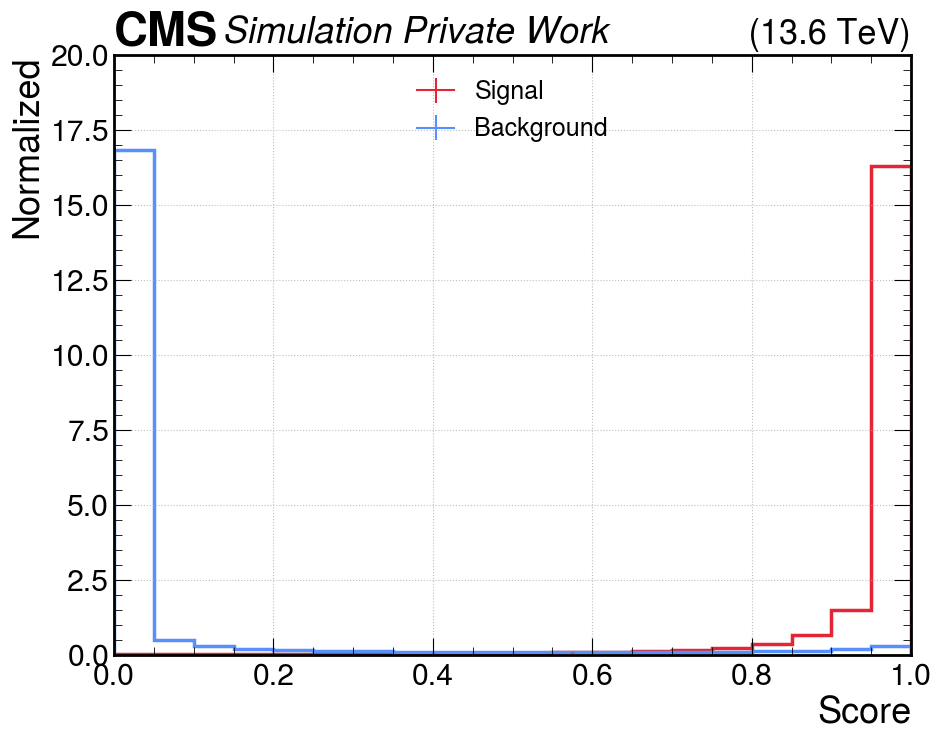

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))

fpr, tpr, threshold = roc_curve(targets, scores)
scores_false = scores[targets == 0]
scores_true  = scores[targets == 1]

score_bins = (20, 0, 1)
ax, true_hist = utils.plot_hist_1d(ax=ax, data=scores_true, bins=score_bins,
                                   label="Signal", color='C2', density=True)
ax, false_hist = utils.plot_hist_1d(ax=ax, data=scores_false, bins=score_bins,
                                    xlabel="Score", ylabel="Normalized",
                                    label="Background", color='C0', density=True)
ax.set_ylim(0, 20)
ax.legend(loc='upper center', fontsize=18)
hep.cms.label("Private Work", ax=ax, data=False, com=13.6)

plt.grid()
plt.tight_layout()
plt.show()

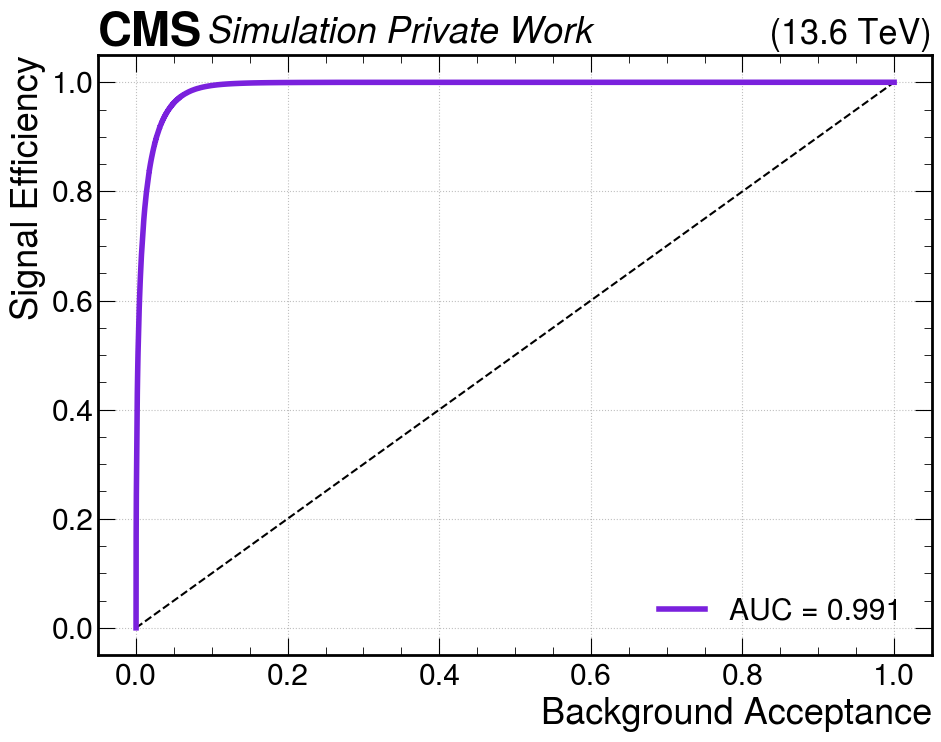

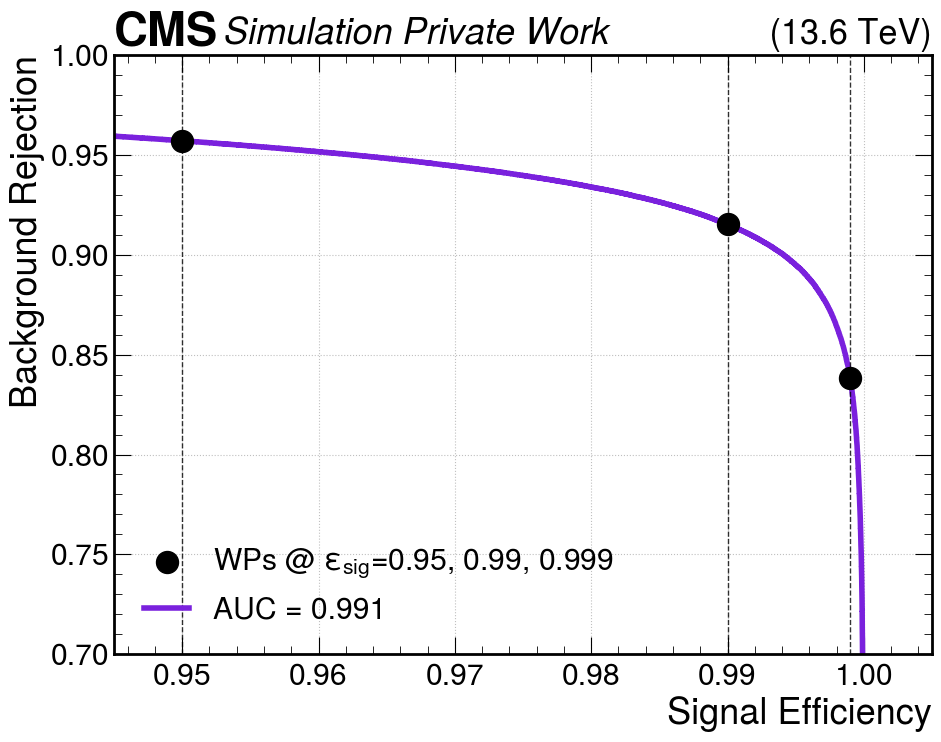

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
fpr, tpr, threshold = roc_curve(targets, scores)

ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.3f}', color='C5', lw=4)

ax.set_xlabel("Background Acceptance")
ax.set_ylabel("Signal Efficiency")
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
hep.cms.label("Private Work", ax=ax, data=False, com=13.6)
plt.grid()
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 8))
tnr = 1.0 - fpr
ax.scatter(None, None, color='black', zorder=10, s=250, label=r"WPs @ $\epsilon_{sig}$=0.95, 0.99, 0.999")
ax.plot(tpr, tnr, alpha=1.0, color='C5', lw=4, label=f'AUC = {auc(fpr, tpr):.3f}')
tpr_cut = [0.95, 0.99, 0.999]
tnr_cut = [tnr[tpr >= cut].max() if np.any(tpr >= cut) else 0.0 for cut in tpr_cut]
for tpr_c, tnr_c in zip(tpr_cut, tnr_cut):
    ax.axvline(x=tpr_c, color='k', linestyle='--', linewidth=1, alpha=0.8)
    ax.scatter(tpr_c, tnr_c, color='black', zorder=10, s=250)
    #ax.text(tpr_c - 0.009, tnr_c + 0.012, r"$R_{bg}: $"+f"{tnr_c:.2f}", fontsize=20, fontweight='bold', color='black', zorder=6)

hep.cms.label("Private Work", ax=ax, data=False, com=13.6)
ax.set_xlabel("Signal Efficiency")
ax.set_ylabel("Background Rejection")
ax.set_xlim(0.945, 1.005)
ax.set_ylim(0.70, 1.00)
plt.legend(loc="lower left")
plt.grid()
plt.tight_layout()
plt.show()

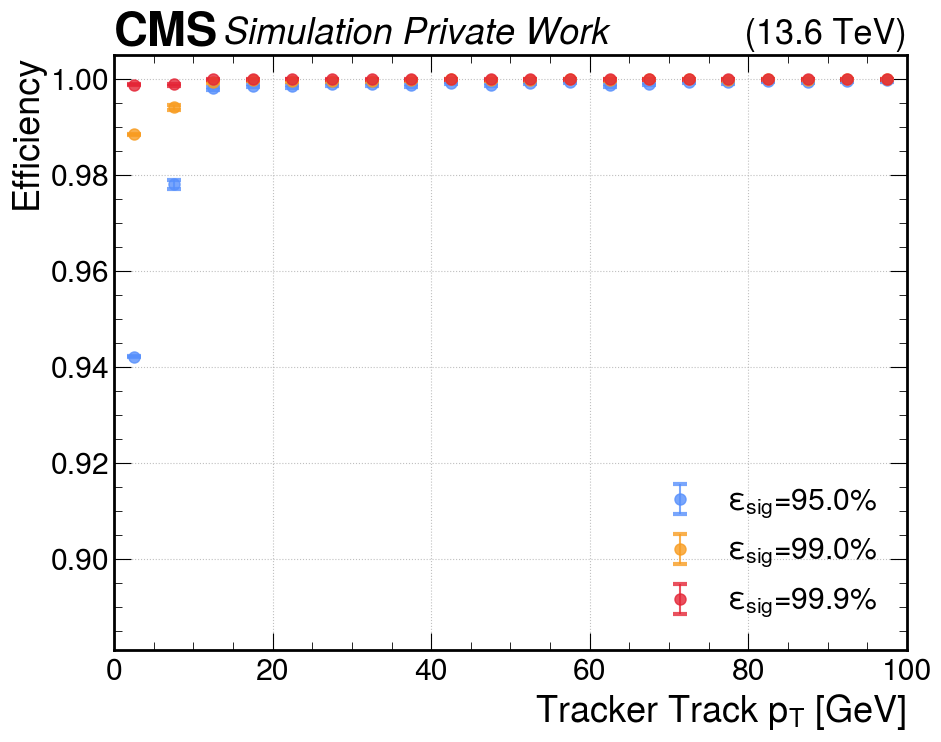

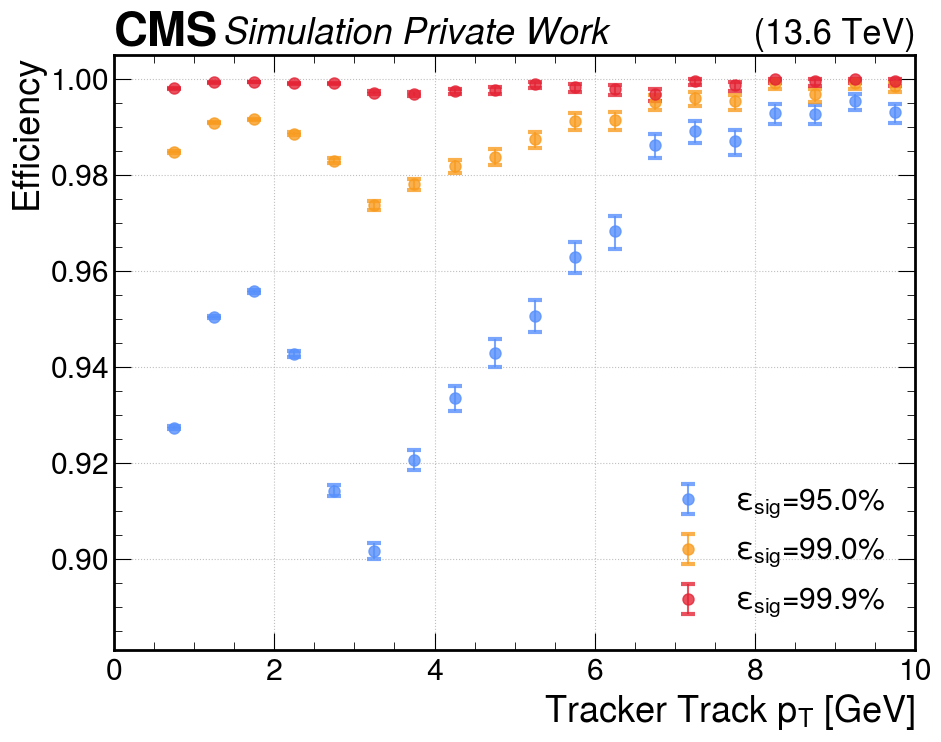

In [23]:
cuts = [0.95, 0.99, 0.999]
colors = ['C0', 'C1', 'C2']

for bins in [(20, 0, 100), (19, 0.5, 10)]:
    fig, ax = plt.subplots(figsize=(10, 8))
    for cut, color in zip(cuts, colors):
        threshold_wp = threshold[tpr > cut].max()
        is_muon = targets == 1
        is_selected = scores >= threshold_wp

        ax, eff_pt = utils.plot_efficiency_1d(
            ax=ax,
            num=track_pts[is_muon & is_selected],
            denom=track_pts[is_muon],
            bins=bins,
            label=r"$\epsilon_{sig}$=" + f"{cut*100}%",
            color=color
        )

    ax.set_xlabel(r"Tracker Track $p_{T}$ [GeV]")
    ax.set_ylabel("Efficiency")
    ax.set_xlim(0, None)
    ax.set_ylim(0.881, 1.005)
    ax.legend(loc='lower right')
    hep.cms.label("Private Work", ax=ax, data=False, com=13.6)
    plt.grid()
    plt.tight_layout()
    plt.show()

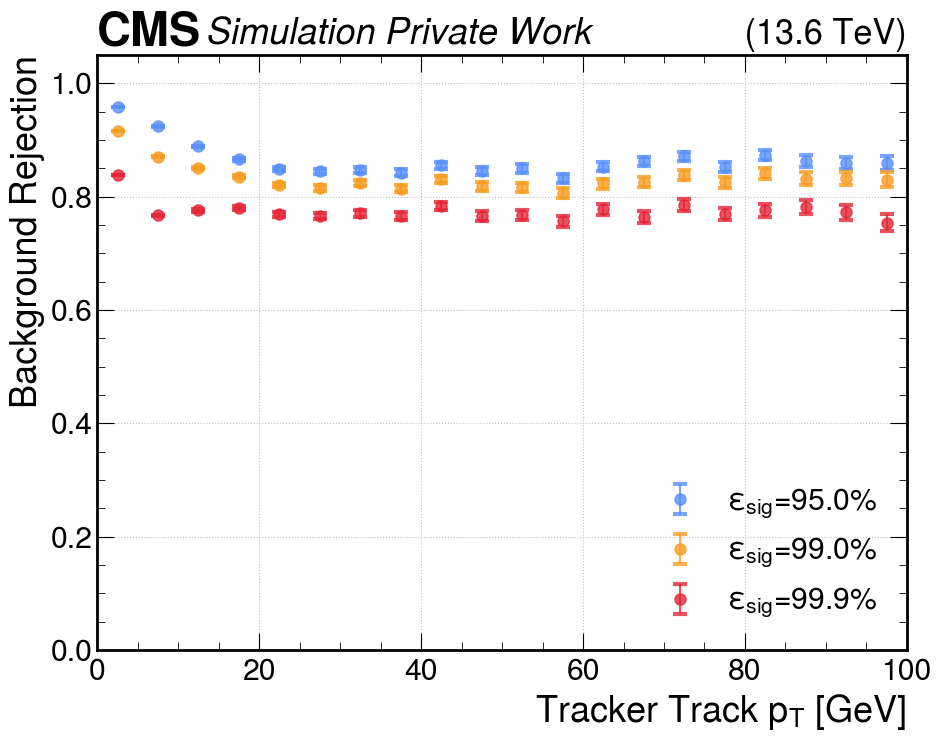

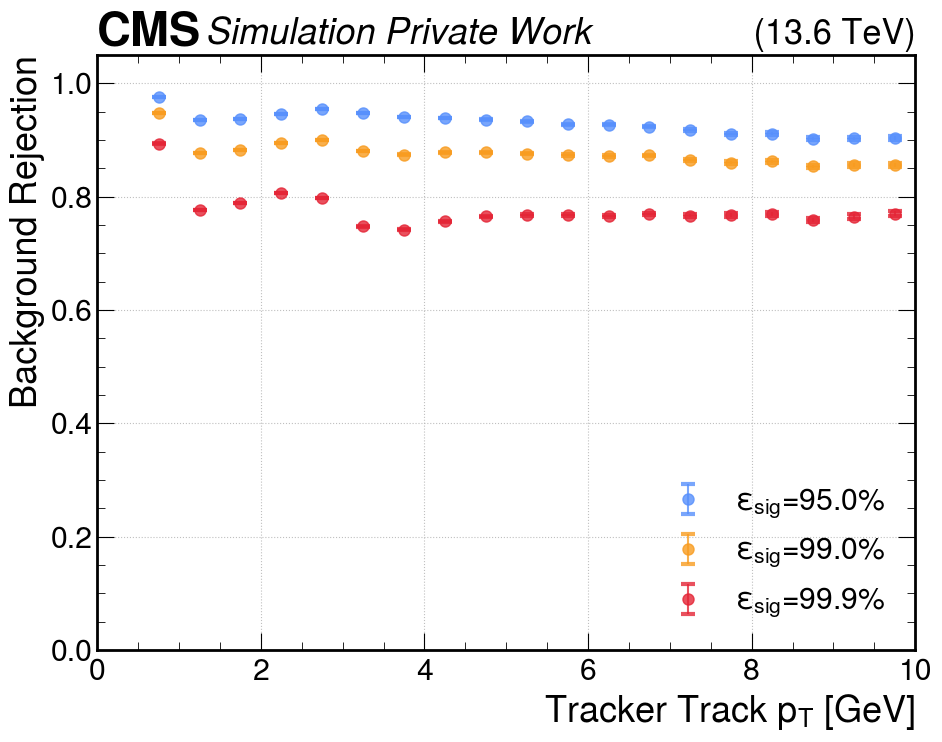

In [24]:
for bins in [(20, 0, 100), (19, 0.5, 10)]:
    fig, ax = plt.subplots(figsize=(10, 8))
    for cut, color in zip(cuts, colors):
        threshold_wp = threshold[tpr > cut].max()
        is_bkg = targets == 0
        is_selected = scores >= threshold_wp

        ax, eff_bkg = utils.plot_efficiency_1d(
            ax=ax,
            num=track_pts[is_bkg & ~is_selected],
            denom=track_pts[is_bkg],
            bins=bins,
            label=r"$\epsilon_{sig}$=" + f"{cut*100}%",
            color=color
        )

    ax.set_xlabel(r"Tracker Track $p_{T}$ [GeV]")
    ax.set_ylabel("Background Rejection")
    ax.set_xlim(0, None)
    ax.set_ylim(0.0, 1.05)
    ax.legend(loc='lower right')
    hep.cms.label("Private Work", ax=ax, data=False, com=13.6)
    plt.grid()
    plt.tight_layout()
    plt.show()

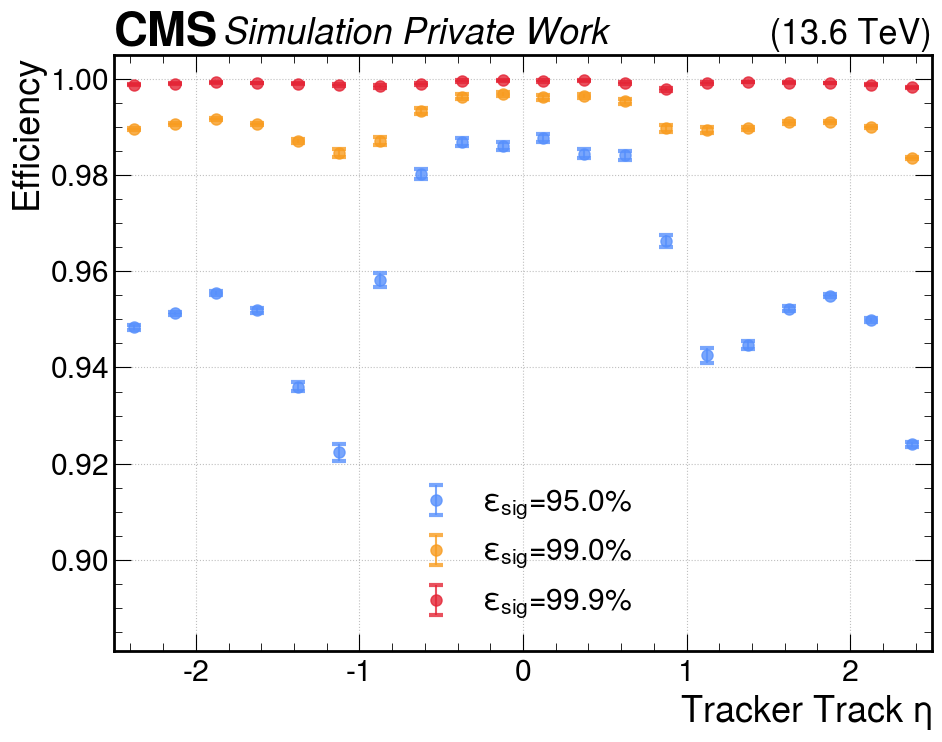

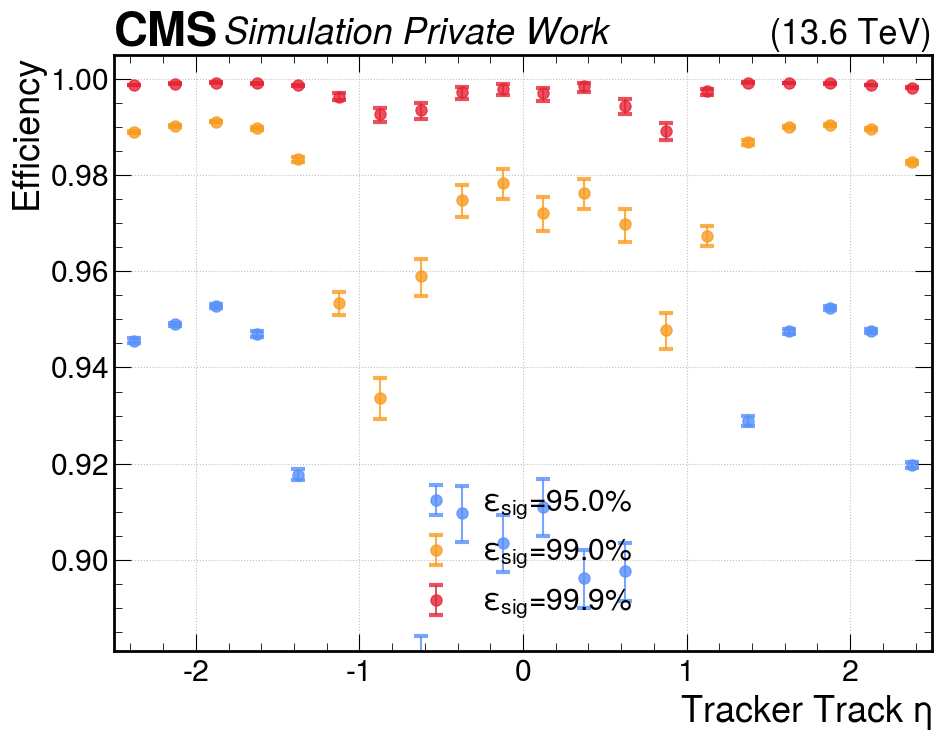

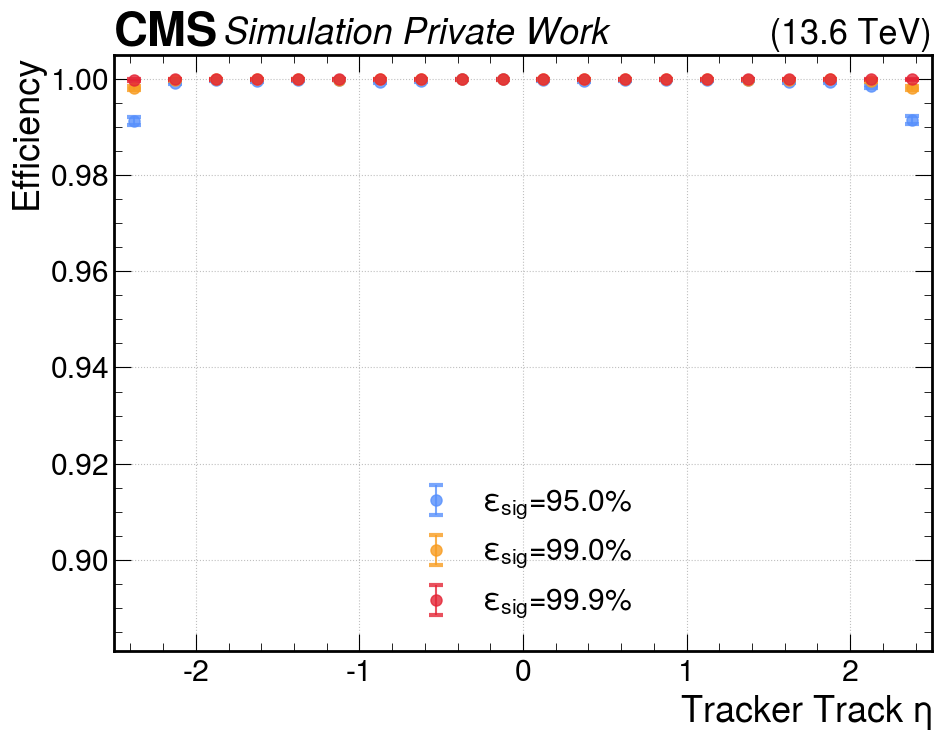

In [26]:
pt_ranges = [
    (0, np.inf),
    (0, 10),
    (10, np.inf)
]

bins = (20, -2.5, 2.5)

for pt_min, pt_max in pt_ranges:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    in_range = (track_pts >= pt_min) & (track_pts < pt_max)
    
    for cut, color in zip(cuts, colors):
        threshold_wp = threshold[tpr > cut].max()
        is_muon = targets == 1
        is_selected = scores >= threshold_wp

        ax, eff_eta = utils.plot_efficiency_1d(
            ax=ax,
            num=track_etas[is_muon & is_selected & in_range],
            denom=track_etas[is_muon & in_range],
            bins=bins,
            label=fr"$\epsilon_{{sig}}$={cut*100:.1f}%",
            color=color
        )

    ax.set_xlabel(r"Tracker Track $\eta$")
    ax.set_ylabel("Efficiency")
    ax.set_ylim(0.881, 1.005)
    ax.legend(loc='lower center')
    hep.cms.label("Private Work", ax=ax, data=False, com=13.6)
    ax.grid()
    plt.tight_layout()
    plt.show()

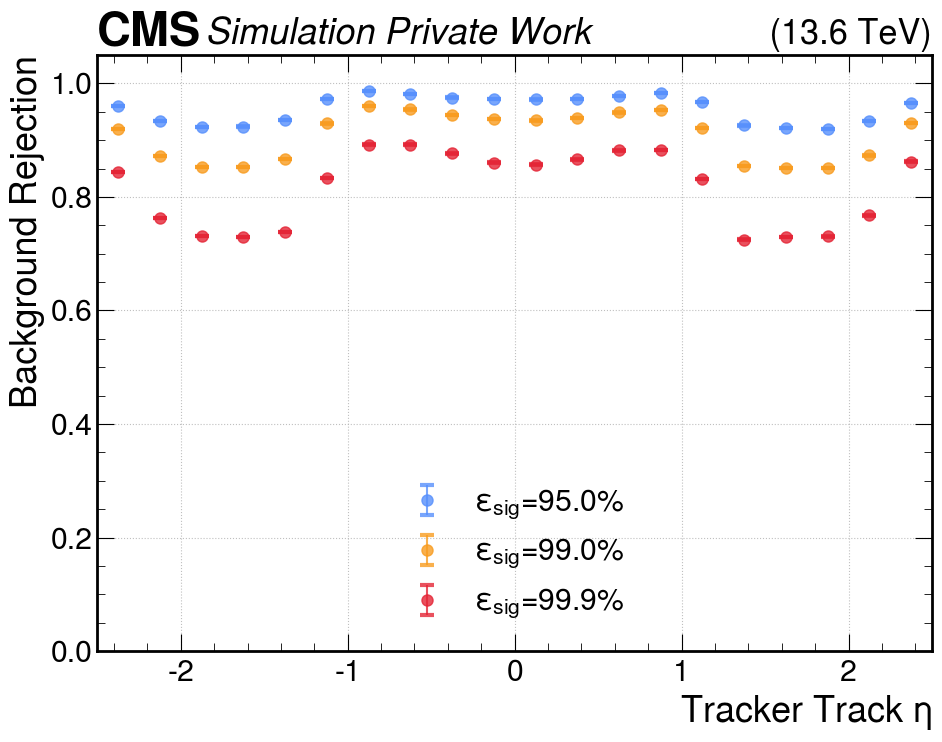

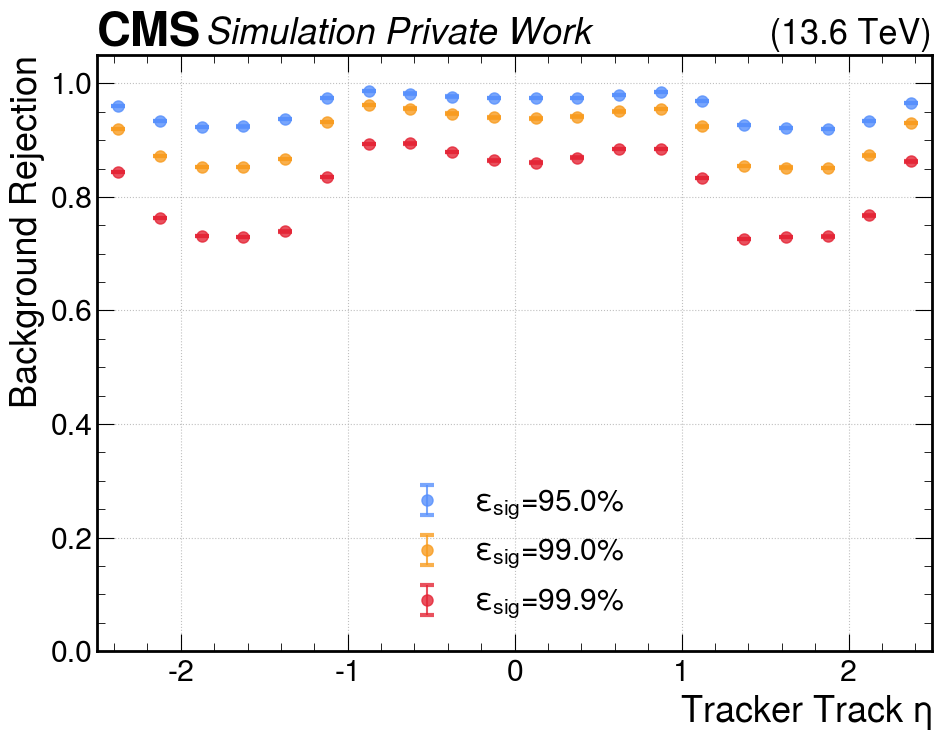

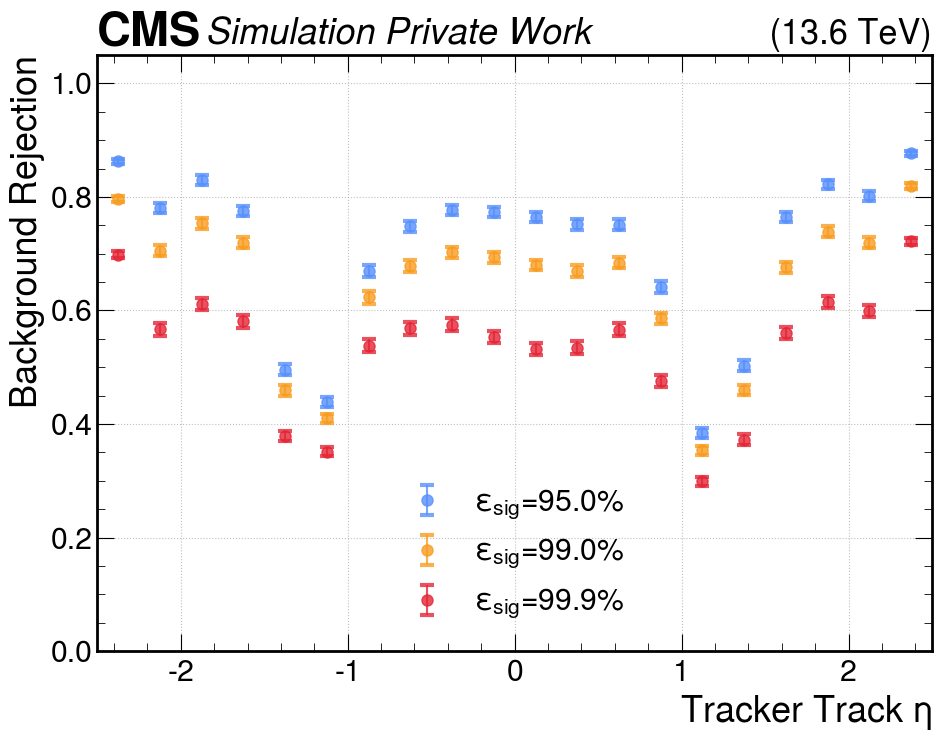

In [25]:
pt_ranges = [
    (0, np.inf),
    (0, 10),
    (10, np.inf)
]

bins = (20, -2.5, 2.5)

for pt_min, pt_max in pt_ranges:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    in_range = (track_pts >= pt_min) & (track_pts < pt_max)
    
    for cut, color in zip(cuts, colors):
        threshold_wp = threshold[tpr > cut].max()
        is_bkg = targets == 0
        is_selected = scores >= threshold_wp
        
        ax, rej_eta = utils.plot_efficiency_1d(
            ax=ax,
            num=track_etas[is_bkg & ~is_selected & in_range],
            denom=track_etas[is_bkg & in_range],
            bins=bins,
            label=fr"$\epsilon_{{sig}}$={cut*100:.1f}%",
            color=color
        )

    ax.set_xlabel(r"Tracker Track $\eta$")
    ax.set_ylabel("Background Rejection")
    ax.set_ylim(0.0, 1.05)
    ax.legend(loc='lower center')
    hep.cms.label("Private Work", ax=ax, data=False, com=13.6)
    ax.grid()
    plt.tight_layout()
    plt.show()

In [15]:
cuts = [0.95, 0.99, 0.999]
threshold_wps = {cut: threshold[tpr > cut].max() for cut in cuts}

# WP별 결과를 dict 형태로 저장
results = {
    cut: {
        "n_tracks": [],
        "n_true_muons": [],
        "n_pred_muons": [],
        "n_pred_true_muons": []
    }
    for cut in cuts
}

single_loader = DataLoader(
    dataset=test_set,
    batch_size=1,
    shuffle=False,
    drop_last=True,
    collate_fn=InnerTrackSelectionDataset.collate,
)

with torch.no_grad():
    model = model.to(device).eval()
    for i, batch in tqdm(enumerate(single_loader)):
        
        target = batch["target"][0]
        output = model(batch)
        score = output["score"][0]
        true_muon = (target == 1)

        # WP별로 계산 반복
        for cut in cuts:
            thr = threshold_wps[cut]
            pred_muon = (score > thr)

            n_track          = len(target)
            n_true_muon      = len(target[true_muon])
            n_pred_muon      = len(score[pred_muon])
            n_pred_true_muon = len(score[pred_muon & true_muon])
            
            results[cut]["n_tracks"].append(n_track)
            results[cut]["n_true_muons"].append(n_true_muon)
            results[cut]["n_pred_muons"].append(n_pred_muon)
            results[cut]["n_pred_true_muons"].append(n_pred_true_muon)

        if i > 20000:
            break

20001it [06:14, 53.43it/s]


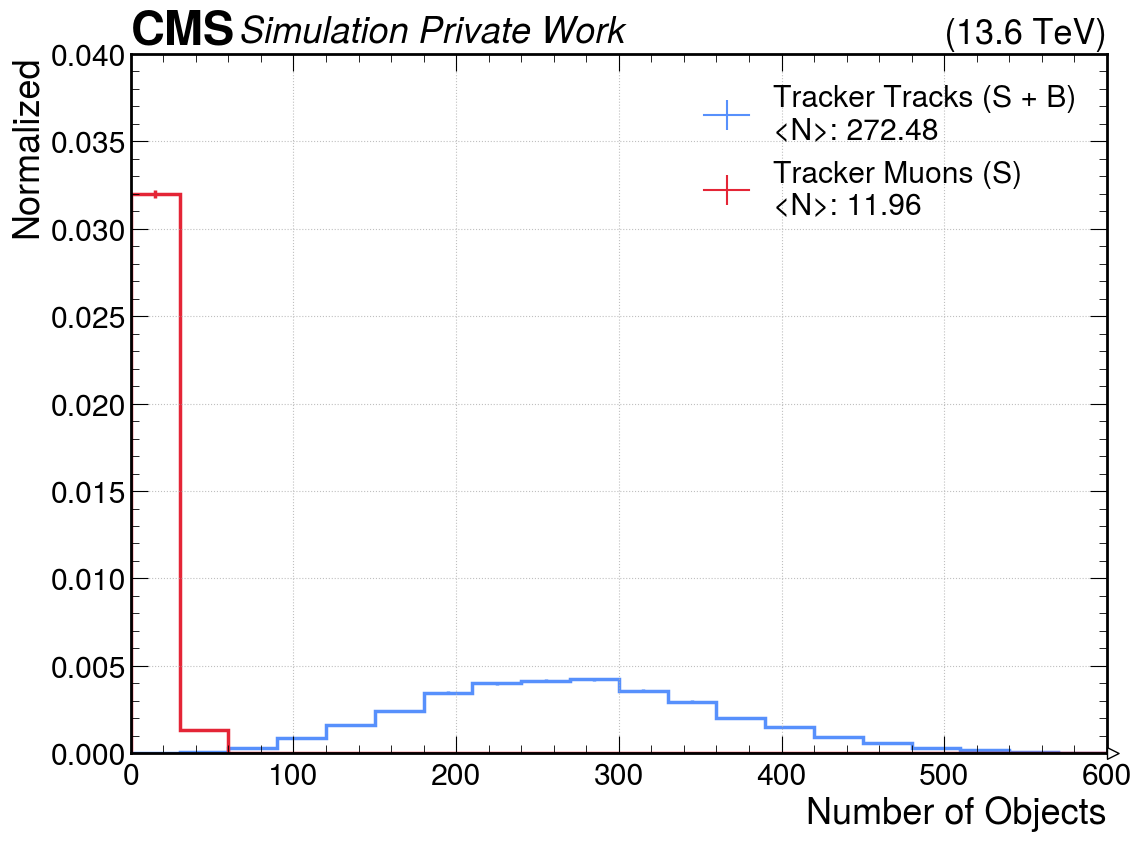

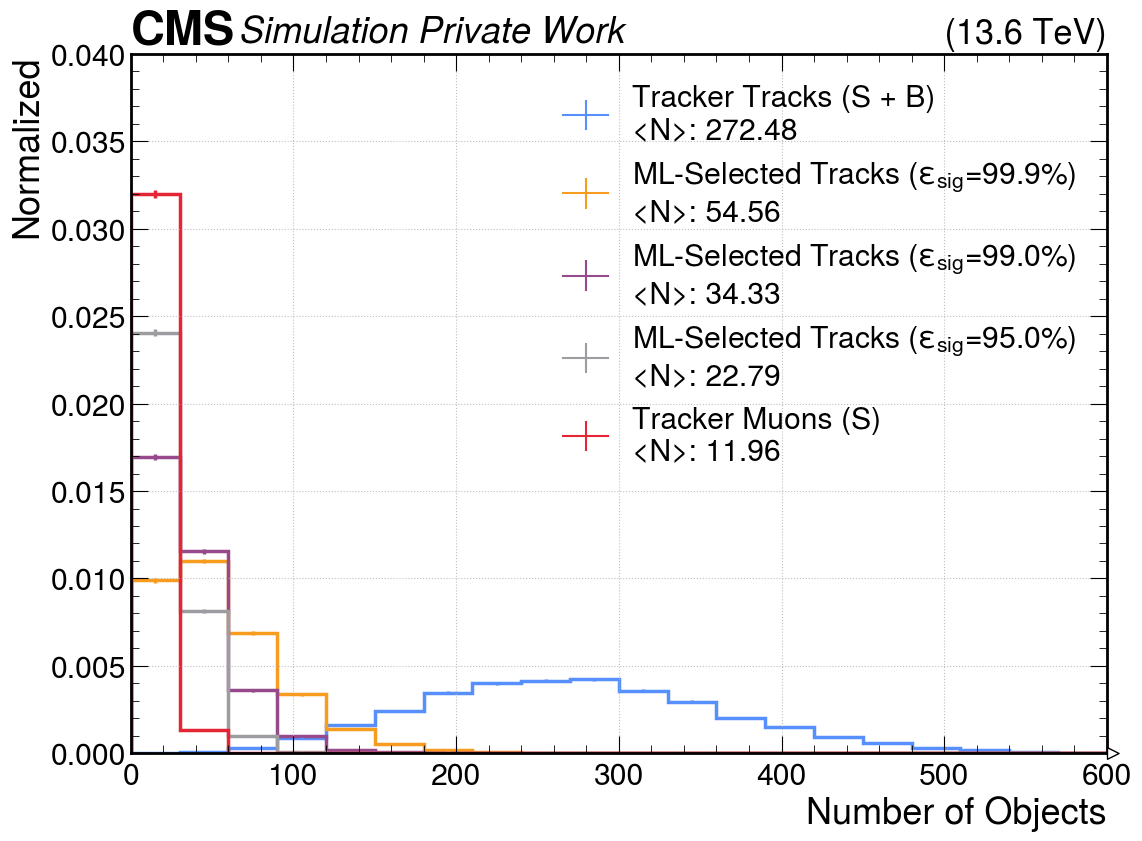

In [37]:
event_bins = (20, 0, 600)

fig, ax = plt.subplots(figsize=(12, 9))

ax, n_track_hist = utils.plot_hist_1d(
    ax=ax,
    data=np.array(results[cuts[0]]["n_tracks"]),
    bins=event_bins,
    label="Tracker Tracks (S + B)\n" + fr"<N>: {np.mean(results[cuts[0]]['n_tracks']):.2f}",
    color='C0',
    density=True
)
ax, n_true_muon_hist = utils.plot_hist_1d(
    ax=ax,
    data=np.array(results[cuts[0]]["n_true_muons"]),
    bins=event_bins,
    label="Tracker Muons (S)\n" + fr"<N>: {np.mean(results[cuts[0]]['n_true_muons']):.2f}",
    color='C2',
    density=True
)

ax.set_xlabel("Number of Objects")
ax.set_ylabel("Normalized")
ax.set_ylim(0, 0.040)
ax.legend(loc='upper right')
hep.cms.label("Private Work", ax=ax, data=False, com=13.6)
plt.grid()
plt.tight_layout()
plt.show()


event_bins = (20, 0, 600)
fig, ax = plt.subplots(figsize=(12, 9))

# 1. Tracker Tracks (S + B)
ax, n_track_hist = utils.plot_hist_1d(
    ax=ax,
    data=np.array(results[0.95]["n_tracks"]),  # 전체 트랙은 모든 WP에서 동일
    bins=event_bins,
    label="Tracker Tracks (S + B)\n" + fr"<N>: {np.mean(results[0.95]['n_tracks']):.2f}",
    color='C0',
    density=True
)

# 2~4. ML-Selected Tracks (각 WP별)
for cut, color in zip([0.999, 0.99, 0.95], ['C1', 'C3', 'C4']):
    ax, n_pred_muon_hist = utils.plot_hist_1d(
        ax=ax,
        data=np.array(results[cut]["n_pred_muons"]),
        bins=event_bins,
        label=r"ML-Selected Tracks ($\epsilon_{sig}$"+ f"={cut*100}%)\n" + fr"<N>: {np.mean(results[cut]['n_pred_muons']):.2f}",
        color=color,
        density=True
    )

# 5. Tracker Muons (S)
ax, n_true_muon_hist = utils.plot_hist_1d(
    ax=ax,
    data=np.array(results[0.95]["n_true_muons"]),
    bins=event_bins,
    label="Tracker Muons (S)\n" + fr"<N>: {np.mean(results[0.95]['n_true_muons']):.2f}",
    color='C2',
    density=True
)

# 스타일 설정
ax.set_xlabel("Number of Objects")
ax.set_ylabel("Normalized")
ax.set_ylim(0, 0.040)
ax.legend(loc='upper right')
hep.cms.label("Private Work", ax=ax, data=False, com=13.6)
plt.grid()
plt.tight_layout()
plt.show()

In [35]:
for cut in [0.95, 0.99, 0.999]:
    tp = np.sum(results[cut]["n_pred_true_muons"])   # true positive
    selected = np.sum(results[cut]["n_pred_muons"])  # total selected
    purity = tp / selected if selected > 0 else 0
    print(f"WP={cut*100:.1f}% → Purity: {purity:.4f} → 1/purity: {1/purity:.2f}")
    

WP=95.0% → Purity: 0.4980 → 1/purity: 2.01
WP=99.0% → Purity: 0.3448 → 1/purity: 2.90
WP=99.9% → Purity: 0.2190 → 1/purity: 4.57
